In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_json( '/content/drive/MyDrive/Data/tweets_covid.json', lines=True)
df.head(10)

,id,created_at,created_at_dayofweek,created_at_hour,username,tweet,hashtags_count,mentions_count,cashtags_count,is_quote_tweet,word_count,character_count,replies_count,retweets_count,likes_count,photos_count,has_video,urls_count
0,1454961380768026624,2021-10-31 23:59:59+00:00,6,23,ioptimizerealty,Your workplace has likely changed due to COVID...,6,0,0,False,42,274,0,0,0,0,False,1
1,1454961376816992258,2021-10-31 23:59:58+00:00,6,23,kiem1642,STOP THE SHOT: Doctors and Hospitals That Deny...,0,0,0,False,18,119,0,0,0,0,False,1
2,1454961362736660481,2021-10-31 23:59:55+00:00,6,23,kremlintrolls,White House Press Secretary Jen Psaki tests po...,0,0,0,False,11,87,1,2,4,0,False,1
3,1454961360643706883,2021-10-31 23:59:54+00:00,6,23,kent_willard,What are we solving for? Zero Covid cases is u...,0,0,0,False,44,263,0,0,0,0,False,0
4,1454961354796900356,2021-10-31 23:59:53+00:00,6,23,dacdac4dac,Narrator: it was not the pandemic.,0,0,0,True,6,34,2,8,93,0,False,0
5,1454961349990174726,2021-10-31 23:59:52+00:00,6,23,causantin,me since the pandemic started tbh,0,0,0,True,6,33,0,0,0,0,False,0
6,1454961349713285120,2021-10-31 23:59:52+00:00,6,23,not_corona_,Girls with glasses can ruin my life 🥲,0,0,0,False,8,37,0,2,3,0,False,0
7,1454961348945879043,2021-10-31 23:59:52+00:00,6,23,combusts,putting a bowl out bc yes im still afraid of c...,0,0,0,False,11,50,0,0,1,0,False,0
8,1454961347549175812,2021-10-31 23:59:51+00:00,6,23,louisehutch,Updated easy to follow #COVID19 guidance #Wal...,3,0,0,False,9,80,0,1,2,1,False,0
9,1454961342373195780,2021-10-31 23:59:50+00:00,6,23,sianchristinak,the fitness and wellness people being the abso...,0,0,0,False,37,189,3,5,100,0,False,0


In [4]:
df.shape

(864804, 18)

In [5]:
df = df[['tweet','likes_count']]

In [6]:
df

,tweet,likes_count
0,Your workplace has likely changed due to COVID...,0
1,STOP THE SHOT: Doctors and Hospitals That Deny...,0
2,White House Press Secretary Jen Psaki tests po...,4
3,What are we solving for? Zero Covid cases is u...,0
4,Narrator: it was not the pandemic.,93
...,...,...
864799,𝗧𝗵𝗲 𝘀𝗲𝗰𝗼𝗻𝗱 𝗲𝗽𝗶𝘀𝗼𝗱𝗲 𝗼𝗳 𝗼𝘂𝗿 𝗶𝗻𝘁𝗲𝗿𝘃𝗶𝗲𝘄 𝘀𝗲𝗿𝗶𝗲𝘀 𝗶𝘀 ...,3
864800,Anyone else have problems breathing on humid d...,1
864801,"Fed's Kaplan on Policy Shift, Guidance, Pandem...",0
864802,Pre pandemic vs now i haven't had a major hai...,0


In [6]:
df = df.drop(df[(df['likes_count'] == 0)].index)

In [7]:
df.shape

(432047, 2)

In [ ]:
df[df['likes_count'] == 1]

,tweet,likes_count
7,putting a bowl out bc yes im still afraid of c...,1
10,The Vax Gives you covid! Research it you will ...,1
22,Roughly 35% to 40% of the world population has...,1
26,Millennium Kids made #GlobalPumpkins tracking ...,1
28,Yeah Utah ended pandemic unemployment in June ...,1
...,...,...
864753,Astonished that Johnson is not taking simple m...,1
864768,The inside story of how the race to develop th...,1
864794,classmate has covid. i didn't come in contact ...,1
864796,"Since 1900s c.76,899 civilians killed in all w...",1


In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


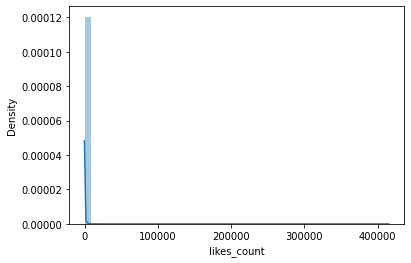

In [ ]:
sns.distplot(df['likes_count'])

In [8]:
df.loc[df['likes_count'] <= 2, 'likes_count'] = 1

In [9]:
df.loc[((df['likes_count'] > 2) & (df['likes_count'] <= 10)) , 'likes_count'] = 2

In [10]:
df.loc[df['likes_count'] > 10 , 'likes_count'] = 3

In [ ]:
df

,tweet,likes_count
2,White House Press Secretary Jen Psaki tests po...,2
4,Narrator: it was not the pandemic.,3
6,Girls with glasses can ruin my life 🥲,2
7,putting a bowl out bc yes im still afraid of c...,1
8,Updated easy to follow #COVID19 guidance #Wal...,1
...,...,...
864792,The Australian Red Cross has teamed up with th...,2
864794,classmate has covid. i didn't come in contact ...,1
864796,"Since 1900s c.76,899 civilians killed in all w...",1
864799,𝗧𝗵𝗲 𝘀𝗲𝗰𝗼𝗻𝗱 𝗲𝗽𝗶𝘀𝗼𝗱𝗲 𝗼𝗳 𝗼𝘂𝗿 𝗶𝗻𝘁𝗲𝗿𝘃𝗶𝗲𝘄 𝘀𝗲𝗿𝗶𝗲𝘀 𝗶𝘀 ...,2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


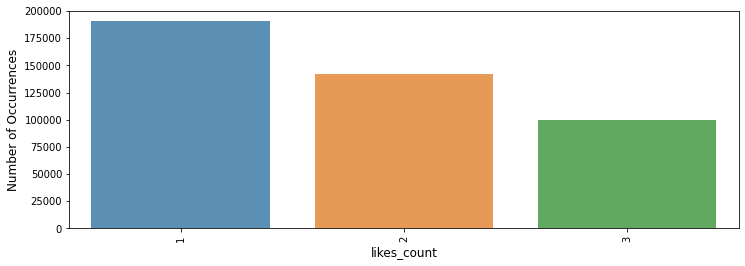

In [11]:
cnt_pro = df['likes_count'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('likes_count', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [12]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [13]:
df['tweet'] = df['tweet'].apply(cleanText)

In [14]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [15]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['tweet']), tags=[r.likes_count]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['tweet']), tags=[r.likes_count]), axis=1)

In [18]:
train_tagged.values[30]

TaggedDocument(words=['new', 'south', 'wales', 'has', 'reported', '282', 'new', 'local', 'cases', 'of', 'covid-19', 'and', 'virus-related', 'death', '7news', 'url'], tags=[2])

In [19]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [20]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 302432/302432 [00:00<00:00, 2943429.96it/s]


In [21]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 302432/302432 [00:00<00:00, 2875348.79it/s]


CPU times: user 16min 55s, sys: 1min 21s, total: 18min 17s
Wall time: 10min 27s


In [22]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [23]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [24]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [25]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.4403194074759866
Testing F1 score: 0.2699155106518789


In [26]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 302432/302432 [00:00<00:00, 2762094.17it/s]


In [27]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 302432/302432 [00:00<00:00, 2867535.82it/s]


CPU times: user 32min 27s, sys: 5min 46s, total: 38min 13s
Wall time: 23min 40s


In [28]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Testing accuracy 0.4372256297496432
Testing F1 score: 0.37226272991941034


In [29]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [30]:
!pip install testfixtures

     |████████████████████████████████| 95 kB 3.8 MB/s 


In [31]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])


In [32]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [33]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [34]:

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Testing accuracy 0.43753423600663505
Testing F1 score: 0.3762390692853275


In [35]:
from sklearn.metrics import confusion_matrix

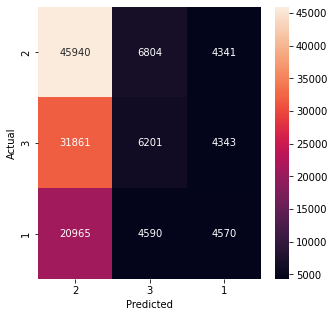

In [36]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df.likes_count.unique(), yticklabels=df.likes_count.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()